# Urban Atlas pre-processing


This notebook creates the mapping between UA landuse and the grid. It also counts the percentage of UA class for each cell.

### Setup

In [113]:
import os,re
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point
# from geopy.distance import vincenty
import osmnx
from sklearn import preprocessing
import pathlib
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 1000

%matplotlib inline

In [114]:
# SET CITY NAME
CITIES = ["barcelona", "london","paris","milan","amsterdam","lisbon"]
CITY_NAME= CITIES[0]

In [116]:
tessellation_sizes = [50,100,200,250]
SIZE = 200

In [117]:
# Base directory
BASE_DIR = os.path.abspath(".")
# base directory for data files
BASE_DIR_DATA = os.path.join(BASE_DIR, "data")
# Base dir for a city data
BASE_DIR_CITY = os.path.join(BASE_DIR_DATA , CITY_NAME)
# Base dir for the city tesselation/grid
BASE_DIR_TESSELLATION = os.path.join(BASE_DIR_CITY, "tessellation")
# Empty tesselation/grid 
TESSELLATION = os.path.join(BASE_DIR_TESSELLATION, "tessellation_"+CITY_NAME +"-Square-"+ str(SIZE) +".geojson")
# Base dir landuse from Urban Atlas
BASE_DIR_LANDUSE = os.path.join(BASE_DIR_CITY, 'landuse')
# City shape fron Nominatim API
OUTPUT_CITY_SHAPE = os.path.join(BASE_DIR_CITY,'osm_raw', CITY_NAME + ".geojson")
#  POIs in Polygon(city shape), output of the clipping operation
OUTPUT_POIS = os.path.join(BASE_DIR_CITY, CITY_NAME +"_POIs.csv")
# Foursquare raw data (formerly known as FOURSQUARE_GRID)
FOURSQUARE_RAW_DATA = os.path.join(BASE_DIR_CITY, 'foursquare_raw', CITY_NAME +"_POIs.csv")



In [118]:
def readShapefile(d):
    p = pathlib.Path(d)
    for sub_path in p.iterdir():
        if sub_path.is_dir():
            for sub_sub_path in sub_path.iterdir():
                if sub_sub_path.is_dir() and sub_sub_path.name== "Shapefiles":
                    for fileName in sub_sub_path.iterdir():
                        if fileName.name.endswith(".shp") and not fileName.name.startswith('Boundary'):
                            return str(fileName.absolute())


# Urban Atlas landuse
UA_LANDUSE = readShapefile(BASE_DIR_LANDUSE)

### Aggregate Land-Use classes

In [119]:
# Load data
landuse = gpd.read_file(UA_LANDUSE)

In [ ]:
# filla Nan
landuse["ITEM2012"] = landuse["ITEM2012"].fillna('Undefined')

In [122]:
# rename classes akin to gonzalez's
# landuse["ITEM2012"].replace(to_replace=["Airports","Port areas"], value="Transportation & Utility", inplace=True)

# High Density Urban Fabric
landuse["ITEM2012"].replace(to_replace="Continuous urban fabric (S.L. : > 80%)", value="High Density Urban Fabric", inplace=True)
landuse["ITEM2012"].replace(to_replace="Discontinuous dense urban fabric (S.L. : 50% -  80%)", value="High Density Urban Fabric", inplace=True)

# Medium Density Urban Fabric
landuse["ITEM2012"].replace(to_replace="Discontinuous medium density urban fabric (S.L. : 30% - 50%)", value="Medium Density Urban Fabric", inplace=True)

# Low Density Urban Fabric
landuse["ITEM2012"].replace(to_replace="Discontinuous low density urban fabric (S.L. : 10% - 30%)", value="Low Density Urban Fabric", inplace=True)
landuse["ITEM2012"].replace(to_replace="Discontinuous very low density urban fabric (S.L. : < 10%)", value="Low Density Urban Fabric", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Isolated structures", value="Low Density Urban Fabric", inplace=True)

# Airports
# NOTE: Commenting line below as it doesn't need to be replaced
# landuse["ITEM2012"].replace(to_replace="Airports", value="Transportation & Utility", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Port areas", value="Transportation & Utility", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Fast transit roads and associated land", value="Transportation & Utility", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Other roads and associated land", value="Transportation & Utility", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Railways and associated land", value="Transportation & Utility", inplace=True)
    
# Green urban areas
# NOTE: Commenting line below as it doesn't need to be replaced
# landuse["ITEM2012"].replace(to_replace="Green urban areas", value="Open Space & Recreation", inplace=True)

# Sports and leisure facilities
# landuse["ITEM2012"].replace(to_replace="Sports and leisure facilities", value="Open Space & Recreation", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)", value="Open Space & Recreation", inplace=True)

# Agrcltrl Seminatural Wetlands
landuse["ITEM2012"].replace(to_replace="Arable land (annual crops)", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Permanent crops (vineyards, fruit trees, olive groves)", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Pastures", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Complex and mixed cultivation patterns", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Orchads", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Wetlands", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)", value="Agrcltrl Seminatural Wetlands", inplace=True)
landuse["ITEM2012"].replace(to_replace="Herbaceous vegetation associations (natural grassland, moors...)", value="Agrcltrl Seminatural Wetlands", inplace=True)

# landuse["ITEM2012"].replace(to_replace="Construction sites", value="Construction Sites", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Mineral extraction and dump sites", value="Construction Sites", inplace=True)

# landuse["ITEM2012"].replace(to_replace="Forest", value="Forests", inplace=True)
# landuse["ITEM2012"].replace(to_replace="Herbaceous vegetation associations (natural grassland, moors...)", value="Forests", inplace=True)

# Water bodies
landuse["ITEM2012"].replace(to_replace="Water", value="Water bodies", inplace=True)

In [125]:
# Aggregate classes
admitted_classes = ['Water bodies','Sports and leisure facilities', 'High Density Urban Fabric','Medium Density Urban Fabric', 'Low Density Urban Fabric', 'Industrial Commercial','Public Units','Green urban areas','Forests','Airports','Agrcltrl Seminatural Wetlands',"Industrial, commercial, public, military and private units"]
landuse_admitted = landuse.loc[landuse['ITEM2012'].isin(admitted_classes)]

In [1]:
#  Re-project data
landuse_admitted = landuse.to_crs({'init':'epsg:3857'})[['ITEM2012','geometry']]

NameError: name 'landuse' is not defined

In [127]:
# Drop NaNs
landuse_admitted.dropna(inplace=True)

In [129]:
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
reshaped_geom = np.array(landuse_admitted.geometry.area/ 10**6).reshape(-1,1)
x_scaled = min_max_scaler.fit_transform(reshaped_geom)
landuse_admitted.loc[:,'coverage'] = x_scaled

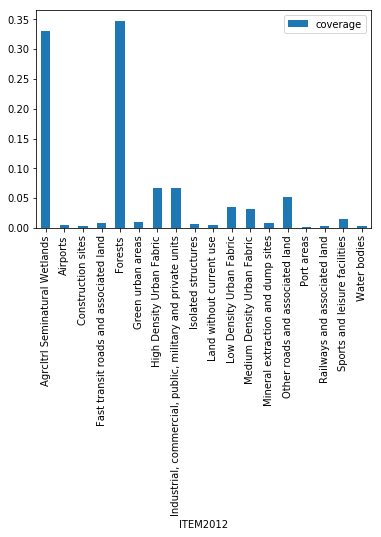

In [131]:
# Quick exploration of the obtained land-use distribution
(landuse_admitted.groupby(['ITEM2012']).sum() / landuse_admitted['coverage'].sum()).plot(kind='bar')

### Subset data
Select only those cells who effectively contain Foursquare POIs

In [134]:
# Load Empty Grid
grid = gpd.GeoDataFrame.from_file(TESSELLATION)

In [135]:
# Re-project
grid = grid.to_crs({"init":"epsg:3857"})

In [136]:
landuse_admitted.geometry = landuse_admitted.geometry.buffer(0)

In [137]:
landuse_rows_initial = landuse_admitted.shape[0]
grid_rows_initial = grid.shape[0]

In [138]:
# Spatial Join
df = gpd.sjoin(grid, landuse_admitted, op='intersects')
df = df.merge(landuse_admitted[['geometry']], left_on='index_right', right_index=True)
df.loc[:, 'intersection'] = df.apply(lambda row : row['geometry_y'].intersection(row['geometry_x']), axis=1)

In [139]:
landuse_rows_sjoin = landuse_admitted.shape[0]
grid_rows_sjoin = grid.shape[0]

In [140]:
df = df.reset_index()[['cellID', 'ITEM2012', 'intersection']]
df.rename(columns={'intersection': 'geometry'}, inplace=True)
df = df.set_geometry('geometry')

### Count percentage of land-use per grid cell

In [141]:
#Compute the column with areas of each landuse in each cell
df['area'] = df.geometry.area

#In order to compute the total area in each cell, group by cellID and sum the area in each group
temp = df[['cellID', 'area']].groupby('cellID').sum()

temp.rename(columns={'area' : 'area_tot'}, inplace=True)
temp = temp.reset_index()

In [143]:
#Merge the temporary dataframe just created with the original one
# Note: it repeates values for columns area_tot, since temp DataFrame has < rows than df DataFrame
# print(len(temp),len(df))
# 4921 29267
df = df.merge(temp, on='cellID')
df['percentage'] = df['area'] / grid.loc[0].geometry.area
df['normalized_percentage'] = df['area'] / df['area_tot']

In [144]:
landuse_rows_merge = landuse_admitted.shape[0]
grid_rows_merge = grid.shape[0]

In [145]:
#Since we care only about general landuse type for each cell, we group by cellID and LandUse,
#summing the percentage of each activity with the same type in each cell
df = df[['normalized_percentage','percentage', 'cellID', 'ITEM2012']].groupby(['cellID', 'ITEM2012']).sum()
df = df.reset_index()

#Compute the list of landuse column names
lu_col = df['ITEM2012'].drop_duplicates()

0                                                          Forests
1                                  Other roads and associated land
6                                    Agrcltrl Seminatural Wetlands
8                                Mineral extraction and dump sites
25                                             Isolated structures
56      Industrial, commercial, public, military and private units
221                                       Low Density Urban Fabric
266                         Fast transit roads and associated land
380                                   Railways and associated land
742                                    Medium Density Urban Fabric
807                                  Sports and leisure facilities
863                                                   Water bodies
942                                              Green urban areas
946                                      High Density Urban Fabric
1193                                            Construction s

In [146]:
r = pd.pivot_table(df, values='percentage', index=['cellID'], columns=['ITEM2012']).reset_index()
r.fillna(0,inplace=True)
r.loc[:, "predominant"] = r[lu_col].idxmax(axis=1)

In [160]:
# Filter out cell with predominant with less than 0.25
r.loc[:,"valid"] = r.apply(lambda x : 1 if x[x['predominant']] > 0.25 else 0, axis=1)
r_pivot = r.shape[0]

In [162]:
# take only the valid cells
r = r[r["valid"] != 0]
r_pivot_valid = r.shape[0]
print("Number of valid cells {valid} \n Number of lost cells: {loss} out of {tot}".format(tot=r_pivot, valid=r_pivot_valid, loss=(r_pivot-r_pivot_valid)))

Number of valid cells 4813 
 Number of lost cells: 108 out of 4921


### Sanity Check:
Where do the select cells fall? Are they just those on the borders of a city?

In [106]:
# merge again with empty grid to have geometry
check_valid_cells_df = r.merge(grid, on='cellID', how='left')

4600 4600 4976


In [151]:
# recast to geoDataFrame
crs = {'init': 'epsg:3857'}
geo_check_valid_cells_df = gpd.GeoDataFrame(check_valid_cells_df, crs=crs, geometry=check_valid_cells_df['geometry']) 

In [152]:
# subset NOT VALID cells
not_valid_cells = geo_check_valid_cells_df[geo_check_valid_cells_df['valid'] == 0]

In [110]:
# subset NOT VALID AND NOT ON THE COAST
not_valid_cells_not_coastal = not_valid_cells.loc[(not_valid_cells['geometry'].centroid.y>5070000) & (not_valid_cells['geometry'].centroid.x<245000)]

In [111]:
print(len(not_valid_cells_not_coastal), len(not_valid_cells))

(72, 216)

In [ ]:
# visual check
f,ax = plt.subplots()
landuse_admitted.plot(ax=ax, color='red')
grid.plot(ax=ax, color='yellow')
geo_check_valid_cells_df.plot(ax=ax, color='grey')
not_valid_cells.plot(ax=ax , color='red')
not_valid_cells_not_coastal.plot(ax=ax , color='yellow')

In [84]:
not_valid_cells_not_coastal.columns[0:-5]

Index(['cellID', 'Agrcltrl Seminatural Wetlands', 'Forests',
       'Green urban areas', 'High Density Urban Fabric',
       'Industrial, commercial, public, military and private units',
       'Low Density Urban Fabric', 'Medium Density Urban Fabric',
       'Sports and leisure facilities', 'Water bodies', 'predominant'],
      dtype='object')

In [88]:
not_valid_cells_not_coastal.head(2)

,cellID,Agrcltrl Seminatural Wetlands,Forests,Green urban areas,High Density Urban Fabric,"Industrial, commercial, public, military and private units",Low Density Urban Fabric,Medium Density Urban Fabric,Sports and leisure facilities,Water bodies,predominant,valid,id,id_x,id_y,geometry
3,3,0.151615,0.003918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Agrcltrl Seminatural Wetlands,0,3,1,69,"POLYGON ((228682.9988183676 5073017.365142888, 228682.9988183676 5073217.365142889, 228882.9988183659 5073217.365142889, 228882.9988183659 5073017.365142888, 228682.9988183676 5073017.365142888))"
11,11,0.000000,0.008947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Forests,0,11,2,69,"POLYGON ((228882.9988183659 5073017.365142888, 228882.9988183659 5073217.365142889, 229082.9988183671 5073217.365142889, 229082.9988183671 5073017.365142888, 228882.9988183659 5073017.365142888))"


In [85]:
not_valid_cells_not_coastal.iloc[:,1:-6].idxmax(axis=1)

3                                    Agrcltrl Seminatural Wetlands
11                                                         Forests
317                                                        Forests
349                                                        Forests
350                                                        Forests
813                                    Medium Density Urban Fabric
824                                                        Forests
1210    Industrial, commercial, public, military and private units
1628    Industrial, commercial, public, military and private units
2104                                   Medium Density Urban Fabric
2275                                 Sports and leisure facilities
2356                                      Low Density Urban Fabric
2427                                 Sports and leisure facilities
2492    Industrial, commercial, public, military and private units
2861                                     High Density Urban Fa